In [2]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib

$$\beta\,u - \frac{d}{dx}\left(m_u\frac{du}{dx}\right)+\beta\,v=f_u\qquad x\in\,(0,L)$$
$$\beta\,v - \frac{d}{dx}\left(m_v\frac{dv}{dx}\right)-\beta\,u=f_v\qquad x\in\,(0,L)$$

cond(Z) = 1718.4205034743115
det(Z) = 2.0917749562853335e+209
monolithic error = 9.023612998582589e-13
{'type': 'dirichlet', 'value': 3.0}
{'type': 'dirichlet', 'value': 8.027171248571467}
{'type': 'dirichlet', 'value': 4.0}
{'type': 'dirichlet', 'value': 3.5334880910911033}


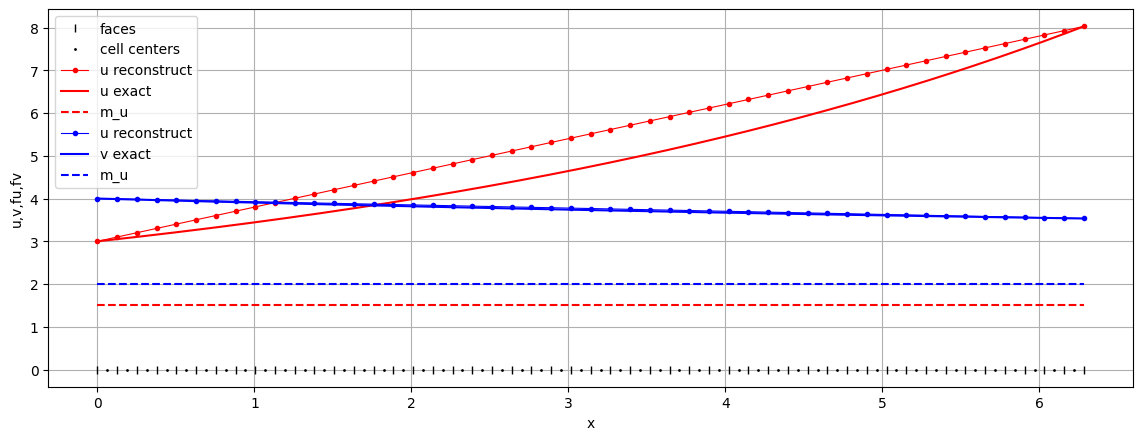

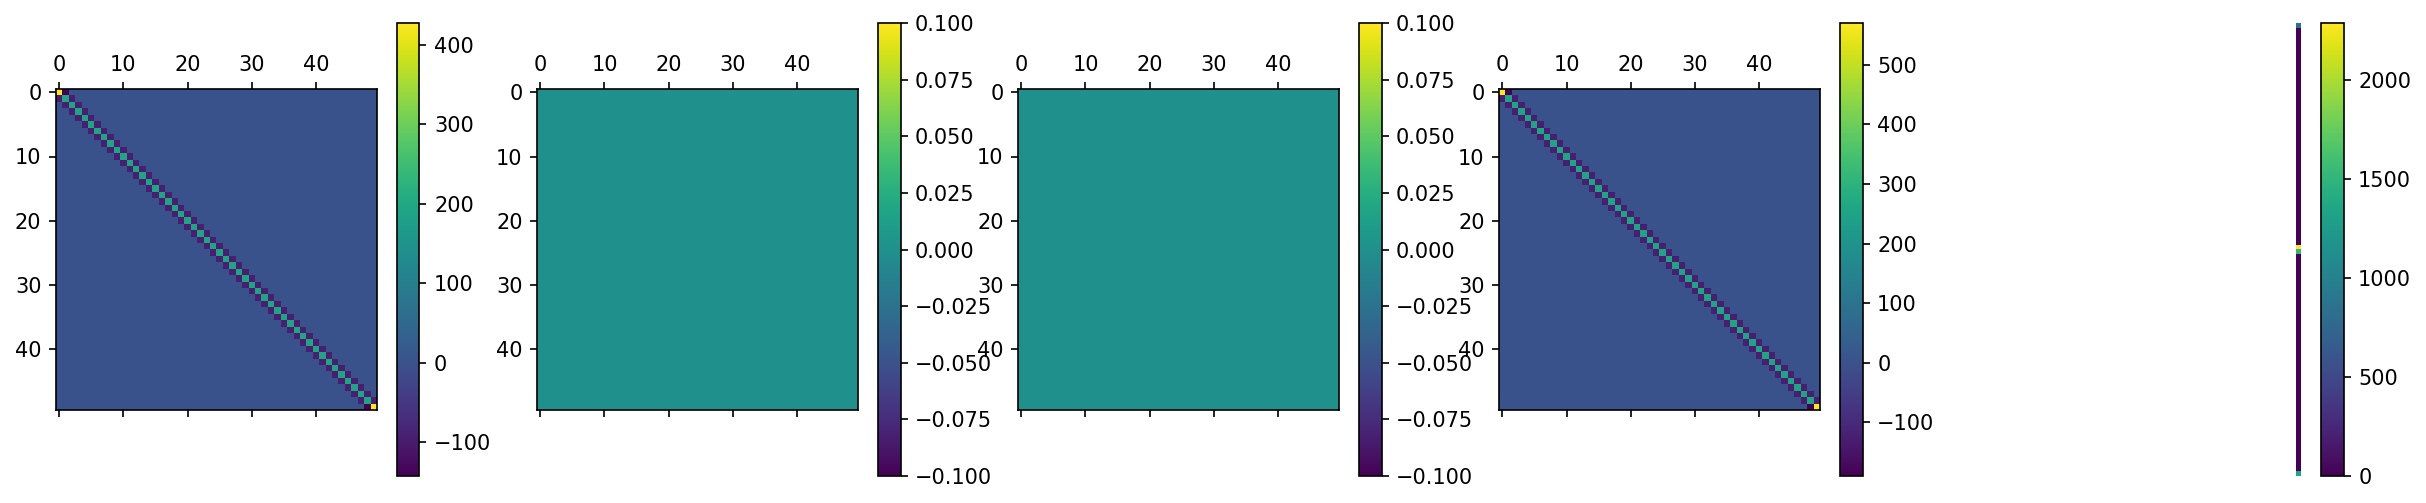

In [ ]:
kwargs = {
    'beta': 0.0,
    'a': 1.0,
    'b': 2.0,
    'c': 0.2,
    'd': 3.0,
    'e': 1.0,
    'f': -0.1,

    'g': 1.5,
    'h': 0.0,
    'l': 1.0,
    'm': 2.0,
    'n': 0.0,
    'p': 5.0
}

def m_u(x, kwargs):
    return kwargs['g'] + kwargs['h']*np.sin(kwargs['l']*x)

def m_v(x, kwargs):
    return kwargs['m'] + kwargs['n']*np.sin(kwargs['p']*x)

def sol_u(x, kwargs):
    return kwargs['a'] + kwargs['b']*np.exp(kwargs['c']*x)

def sol_v(x, kwargs):
    return kwargs['d'] + kwargs['e']*np.exp(kwargs['f']*x)

def f_u(x, kwargs):
    beta = kwargs['beta']
    a = kwargs['a']
    b = kwargs['b']
    c = kwargs['c']
    d = kwargs['d']
    e = kwargs['e']
    f = kwargs['f']
    g = kwargs['g']
    h = kwargs['h']
    l = kwargs['l']
    m = kwargs['m']
    n = kwargs['n']
    p = kwargs['p']
    return beta*((a-d)+(b*np.exp(c*x)-e*np.exp(f*x))) - b*c*np.exp(c*x)*(c*(g+h*np.sin(l*x))+l*h*np.cos(l*x))

def f_v(x, kwargs):
    beta = kwargs['beta']
    a = kwargs['a']
    b = kwargs['b']
    c = kwargs['c']
    d = kwargs['d']
    e = kwargs['e']
    f = kwargs['f']
    g = kwargs['g']
    h = kwargs['h']
    l = kwargs['l']
    m = kwargs['m']
    n = kwargs['n']
    p = kwargs['p']
    return -beta*((a-d)+(b*np.exp(c*x)-e*np.exp(f*x))) - e*f*np.exp(p*x)*(f*(m+n*np.sin(p*x))+n*p*np.cos(p*x))

L = 2.0*np.pi
N = 20
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

leftBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_u(0.0, kwargs)}

rightBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_u(L, kwargs)}

leftBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_v(0.0, kwargs)}

rightBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_v(L, kwargs)}

A_lapl, fuBC = mylib.laplacian(m_u, leftBC_u, rightBC_u, N, dx, L, kwargs)
A = kwargs['beta']*sparse.eye(N) - A_lapl

B = -kwargs['beta']*sparse.eye(N)
C = -kwargs['beta']*sparse.eye(N)

D_lapl, fvBC = mylib.laplacian(m_v, leftBC_v, rightBC_v, N, dx, L, kwargs)
D = kwargs['beta']*sparse.eye(N) - D_lapl

fu =  - fuBC #f_u(xc, kwargs)
fv =  - fvBC #f_v(xc, kwargs)

A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A
Z[:N,N:] = B
Z[N:,:N] = C
Z[N:,N:] = D

f = np.concatenate((fu,fv))

sol = linalg.solve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.reconstruct(u)
v_rec = mylib.reconstruct(v)

print("cond(Z) =", np.linalg.cond(Z))
print("det(Z) =", np.linalg.det(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")
print(leftBC_u)
print(rightBC_u)
print(leftBC_v)
print(rightBC_v)

fig, ax = plt.subplots(figsize=(14,5), dpi=100)
markersize = 20
linewidth = 0.8
ax.set_xlabel('x')
ax.set_ylabel('u,v,fu,fv')

ax.plot(x, 0*x, '|', color='k', label='faces', markersize=6.0)
ax.plot(xc, 0*xc, '.', color='k', label='cell centers', markersize=2.0)

ax.plot(x, mylib.reconstruct(u), '.-r' , label='u reconstruct', linewidth=linewidth)
#ax.plot(xc, u, '_r', label='u cell', markersize=markersize)
ax.plot(xfine, sol_u(xfine, kwargs), '-r', label='u exact')
ax.plot(xfine, m_u(xfine, kwargs), '--r', label='m_u')

ax.plot(x, mylib.reconstruct(v), '.-b' , label='u reconstruct', linewidth=linewidth)
#ax.plot(xc, v, '_b', label='v cell', markersize=markersize)
ax.plot(xfine, sol_v(xfine, kwargs), '-b', label='v exact')
ax.plot(xfine, m_v(xfine, kwargs), '--b', label='m_u')

#ax.plot(x, mylib.reconstruct(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax.plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax.plot(xfine, f(xfine, kwargs), '--k', label='f exact')

#ax.set_ylim(bottom=0.0)
#ax.set_xlim([-0.001,0.1])
ax.legend()
ax.grid()

fig1, axs = plt.subplots(1, 5, figsize=(20,4), dpi=150)
axsA = axs[0].matshow(A)
axsB = axs[1].matshow(B)
axsC = axs[2].matshow(C)
axsD = axs[3].matshow(D)
axsf = axs[4].matshow(f.reshape((2*N,1)))
fig1.colorbar(axsA, ax=axs[0])
fig1.colorbar(axsB, ax=axs[1])
fig1.colorbar(axsC, ax=axs[2])
fig1.colorbar(axsD, ax=axs[3])
fig1.colorbar(axsf, ax=axs[4])
axs[4].axis('off')
#plt.savefig('matrix.pdf')
plt.show()